## *Imports*

In [1]:
import sys # system functions (ie. exiting the program)
import os # operating system functions (ie. path building on Windows vs. MacOs)
import time # for time operations
import uuid # for generating unique file names
import math # math functions
import io
import PIL.Image 

from IPython.display import display as ipydisplay, Image, clear_output, HTML # for interacting with the notebook better

import numpy as np # matrix operations (ie. difference between two matricies)
import cv2 # (OpenCV) computer vision functions (ie. tracking)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

import matplotlib.pyplot as plt # (optional) for plotting and showing images inline
%matplotlib inline

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model, model_from_json
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
print('Keras image data format: {}'.format(K.image_data_format()))

OpenCV Version: 4.2.0
Keras image data format: channels_last


## *Set up reference folders and files*

In [2]:
IMAGES_FOLDER = 'images' 
MODEL_FOLDER = 'model'
MODEL_FILE = os.path.join(MODEL_FOLDER, 'hand_model_gray.hdf5') # path to model weights and architechture file
MODEL_HISTORY = os.path.join(MODEL_FOLDER, 'model_history.txt') # path to model training history

## *Tools*

### Displaying images

#### Fix colour channel ordering for plotting

Matplotlib and OpenCV order colour channels in image matricies slightly differently, RGB and BGR respectively. We need to reorder the colour channels if we want to plot OpenCV images with Matplotlib.

In [3]:
def bgrtorgb(image):
    return cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)

#### Jupyter Notebook image display

In [4]:
def show_image(name):
    """
    Showing image files.
    """
    fname = os.path.join(IMAGES_FOLDER, name)
    ipydisplay(Image(fname))

In [5]:
def plot_image(image, figsize=(8,8), recolour=False):
    """
    Plotting image matricies.
    """
    if recolour: image = bgrtorgb(image)
    plt.figure(figsize=figsize)
    if image.shape[-1] == 3:
        plt.imshow(image)
    elif image.shape[-1] == 1 or len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        raise Exception("Image has invalid shape.")
    plt.show()

# Image Processing

### What computers see

Computers 'look' at images as multidimensional arrays or matricies but they can also be treated like functions (ex. taking the derivative over an image's x-axis).

Below an image is loaded from the file system and loaded into memory. This matrix is 387 x 600 x 3 which represents the number of rows x number of columns x number of colour channels (RGB/BGR).

We can then plot that data to view the image.

Note: When images are loaded in OpenCV, they return BGR (blue, green, red) channels, where as matplotlib expects RGB (red, green, blue). Therefore, we need  to convert the loaded image matrix from BGR to RGB.

Image Plotted:


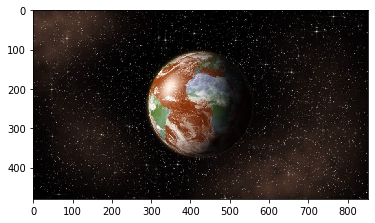

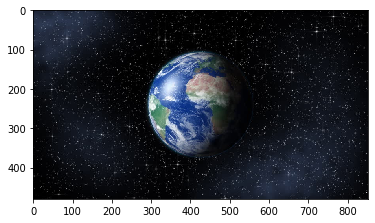

Image Shape:  (480, 852, 3)         |         (height, width, nr channels) in pixels


Image Matrix: 
 [[[26 33 51]
  [26 33 51]
  [26 33 51]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[26 33 51]
  [26 33 51]
  [27 34 52]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[26 33 51]
  [27 34 52]
  [27 34 52]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  ...
  [ 3  3  5]
  [ 3  3  5]
  [ 3  3  5]]] 




In [6]:
earth_fname = os.path.join(IMAGES_FOLDER, 'earth.jpg')
earth_img = cv2.imread(earth_fname)
print('Image Plotted:')
plt.imshow(earth_img)
plt.show()
earth_img = cv2.cvtColor(earth_img, cv2.COLOR_BGR2RGB)
plt.imshow(earth_img)
plt.show()

print('Image Shape: ', earth_img.shape, '        |         (height, width, nr channels) in pixels\n\n')
print('Image Matrix: \n', earth_img, '\n\n')

An image is a 2D array of pixel values, which is equivalent to a 3D array of RGB values.
So manipulating an image simply means changing the RGB values associated to a specific pixel at a position.

It is very easy to do this in python for different conditions:

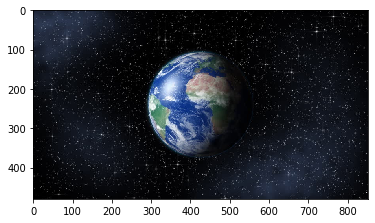

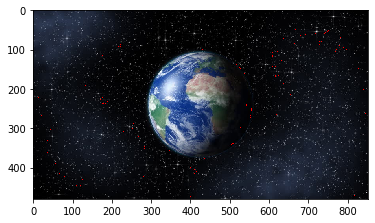

In [7]:
applied_color = [255, 0, 0]
earth_img_custom = earth_img.copy()
earth_img_custom[np.where(np.all(earth_img==earth_img[400,400], axis=-1))] = applied_color
plt.imshow(earth_img)
plt.show()
plt.imshow(earth_img_custom)
plt.show()

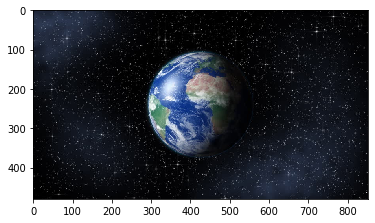

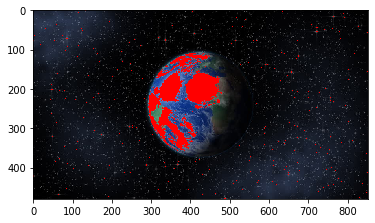

In [8]:
threshold = 100
applied_color = [255, 0, 0]
earth_img_custom = earth_img.copy()
earth_img_custom[np.where(earth_img[:,:,0]>threshold)] = applied_color
plt.imshow(earth_img)
plt.show()
plt.imshow(earth_img_custom)
plt.show()

### Image Filters and Functions

Many times, images contain complex information that isn't need for a computation or reduces the speed of computation without much value added.

#### Blurring


Blurring is useful when there is noise in an image you want to remove.

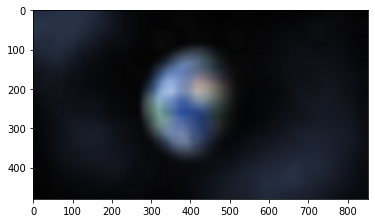

In [9]:
kernel_size = 50
box_blur_img = earth_img.copy()
box_blur_img = cv2.blur(box_blur_img, (kernel_size, kernel_size))
plt.imshow(box_blur_img)
plt.show()

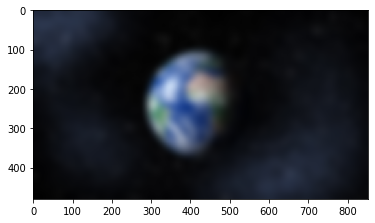

In [10]:
kernel_size = 41
variance = 10
blur_img = earth_img.copy()
blur_img = cv2.GaussianBlur(blur_img, (kernel_size, kernel_size), variance)
plt.imshow(blur_img)
plt.show()

#### Sharpening 
Try it yourself using the blurred version of the image above!

#### Dilating

Dilation, as it sounds, dilates pixel neighbourhoods by finding maximums over the image by the kernel size given. This is useful for expanding selections (we'll look at this later).

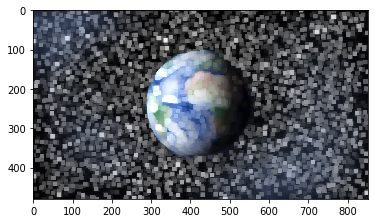

In [11]:
kernel_size = 10
dilate_img = earth_img.copy()
dilate_img = cv2.dilate(dilate_img, np.ones((kernel_size, kernel_size), dtype=np.uint8), iterations=1)
plt.imshow(dilate_img)
plt.show()

#### Erosion

Erosion is the opposite of dilation, useful for remove noise.

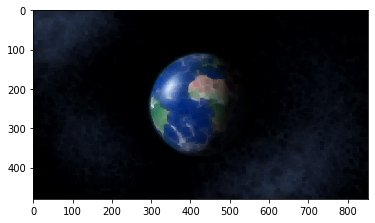

In [12]:
kernel_size = 10
erosion_img = earth_img.copy()
erosion_img = cv2.erode(erosion_img, np.ones((kernel_size, kernel_size), dtype=np.uint8), iterations=1)
plt.imshow(erosion_img)
plt.show()

#### Canny edge detector

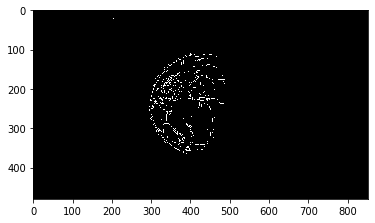

In [13]:
canny_img = earth_img.copy()
canny_img = cv2.erode(canny_img, np.ones((12,12), dtype=np.uint8), iterations=1)
thresh = 75
edges = cv2.Canny(canny_img, thresh, thresh)
plt.imshow(edges.astype(np.uint8), cmap='gray')
plt.show()

#### Thresholding

Thresholding can be thought of as a function applied to each pixel of an image. This function takes a min and max thresholding values and if the pixel value falls in this range, it will 'return' the pixel, if not it will 'return' a black pixel.

Generally, thresholding is applied to a greyscale image, but may also be applied to colour images, following a similair principle.

Max value: 60
Min value: 0
Set of values: [ 0 60]


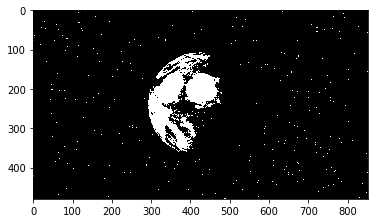

In [14]:
thresh_img = earth_img.copy()
threshold = 100
pinning_value = 255
thresh_img = cv2.cvtColor(thresh_img, cv2.COLOR_RGB2GRAY)
ret, thresh = cv2.threshold(thresh_img, threshold, 60, cv2.THRESH_BINARY)
print("Max value:", np.max(thresh))
print("Min value:", np.min(thresh))
print("Set of values:", np.unique(thresh))
plt.imshow(thresh, cmap='gray')
plt.show()

### Background Subtraction Techniques

#### Using a background image to find differences (can be used for images and video)

This technique requires a background image to find the difference between the background and the current frame to find what as changed. This difference creates a 'mask' that represents where in the image the foreground is. A draw back of this algorithm is that any movement of the camera, change of lighting, change in focus, etc. will make the current frame totally different from the background image.

The algorithm:
* load in the background image and the current frame
* find the absolute difference between the images
* create a mask of the difference between the two frames by applying a threshold to the values of the difference.
* apply the mask to the current frame to extract the foreground by iterating over each pixel and copying all pixels from the current frame that should be part of the foreground

Image 1:


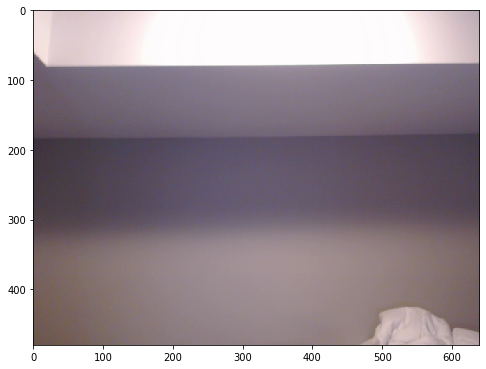

Image 2:


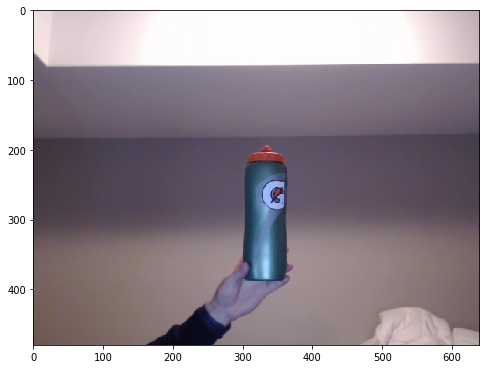

Difference image:


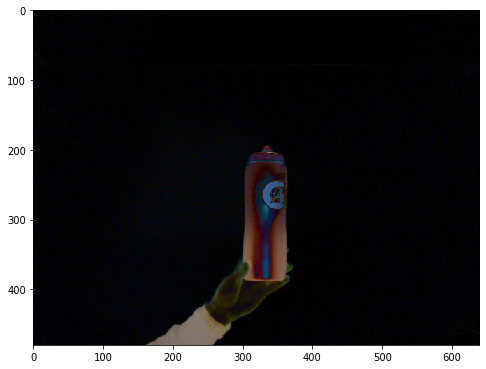

Applying threshold:


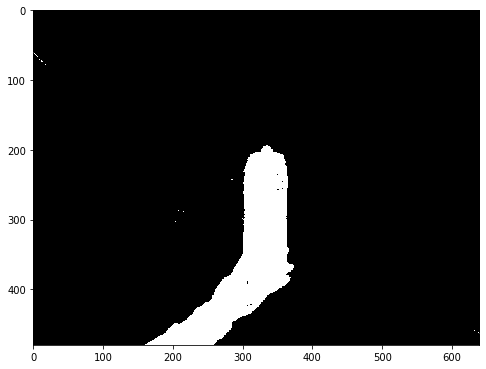

Isolating foreground:


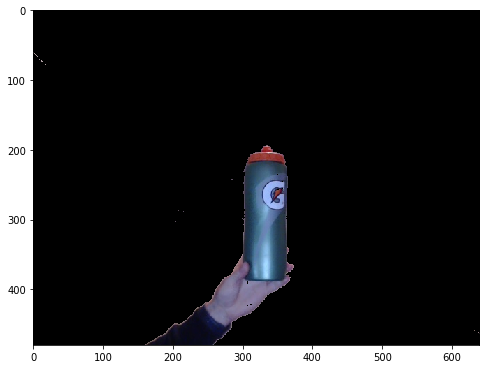

In [15]:
# Load the two frames
bg_img = cv2.imread(os.path.join(IMAGES_FOLDER, 'bg.jpg'))
current_frame_img = cv2.imread(os.path.join(IMAGES_FOLDER, 'current_frame.jpg'))

# Subtract one frame (i.e. corresponding pixel values) to the other
diff = cv2.absdiff(bg_img, current_frame_img)

# Converting the difference to grayscale and applying a threshold
mask = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
th, mask_thresh = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)

# Isolating the foreground
mask_indexes = mask_thresh > 0
foreground = np.zeros_like(current_frame_img, dtype=np.uint8)
for i, row in enumerate(mask_indexes):
    foreground[i, row] = current_frame_img[i, row]
    
print("Image 1:")
plot_image(bg_img, recolour=True)
print("Image 2:")
plot_image(current_frame_img, recolour=True)
print("Difference image:")
plot_image(diff, recolour=True)
print("Applying threshold:")
plot_image(mask_thresh, recolour=True)
print("Isolating foreground:")
plot_image(foreground, recolour=True)

#### Using motion based background subtraction algorithms (mainly video)

These algorithms are most used for video. The algorithm looks at a series of frames and computes which pixels are most static and identifies the foreground by the pixels that are moving. The MOG2 and KNN background subtractors are two different algorithms.

In [16]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

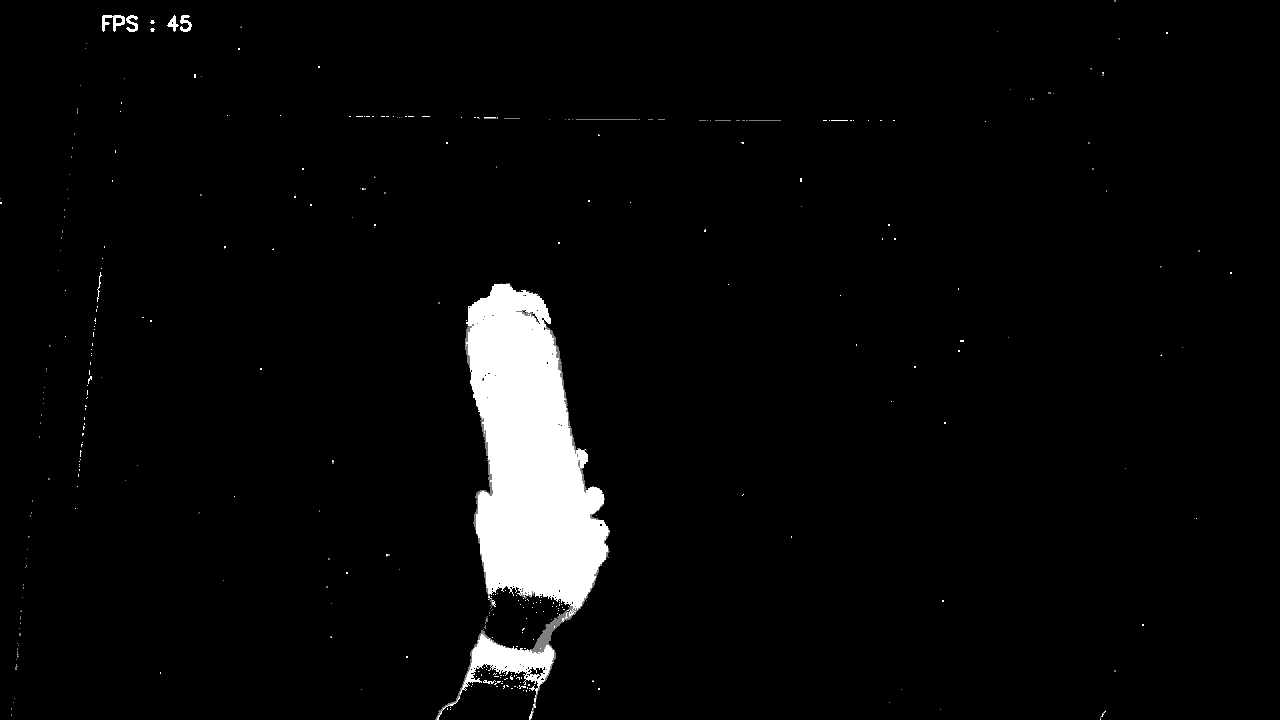

In [17]:
ERODE = False

fgbg = cv2.createBackgroundSubtractorMOG2()
# fgbg = cv2.createBackgroundSubtractorKNN()

# Load the video
video = cv2.VideoCapture(os.path.join(IMAGES_FOLDER, 'bg_subtract_movement.mp4'))

while True:
    # Wait before processing next frame
    time.sleep(0.025)
    timer = cv2.getTickCount()

    # Read a new frame but break if frame not successfully read
    success, frame = video.read()
    if not success:
        break
    
    # Apply the background subtractor to the current frame
    fgmask = fgbg.apply(frame)
    
    # Apply erosion to clean up noise
    if ERODE:
        fgmask = cv2.erode(fgmask, np.ones((3,3), dtype=np.uint8), iterations=1)
    
    # Calculate Frames per second (FPS)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    
    # Display FPS on frame
    cv2.putText(fgmask, "FPS : " + str(int(fps)), (100, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 255, 255), 2)

    # Display result
    clear_output(wait=True)
    showarray(fgmask)
        
video.release()

#  (Deep) Neural Networks (NN/DNN)

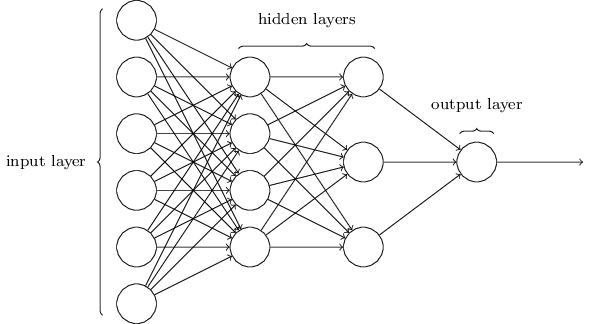

In [18]:
show_image("neuralnetwork.png")

A neural architecture as the one presented in the image above is known as Multilayer perceptron: each of the neurons of one layer is always connected to each of the previous layer. These type of layers are also called Dense. 
Each of the nodes in the image below is a neuron - simply an entity which holds a number - and each of the arrows/links between the neurons is a weight which is "learnt" by the neuron during training. Therefore the diagram represents the dependency of the sequence of weighted sum operations that take place in a neural network. These weighted sums are followed by a non-linear operation and/or other layers (such as pooling, dropout, batch norm, etc..)

Here we build our neural network and compile it with a loss function and optimizers of our choice.

Before we can build any neural networks we need to import a few things from Keras and prepare our data. The following code extracts the MNIST dataset, provided by Keras, and flattens the 28x28 pixel images into a vector with length 784. Additionally, it modifies the labels from a numeric value 0-9 to a one-hot encoded vector.

In [19]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from random import randint

# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)

# Convert class vectors to binary class matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

### A Look At Some Random Digits

It's a good idea to get a sense of the dataset we're working with. Run this code multple times to see new randomly selected digits from the training set. 

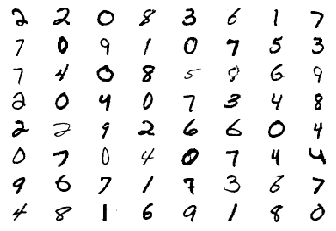

In [20]:
for i in range(64):
    ax = plt.subplot(8, 8, i+1)
    ax.axis('off')
    plt.imshow(x_train_drawing[randint(0, x_train.shape[0])], cmap='Greys')

### First Network

Here is a first, simple network, to solve MNIST. It has a single hidden layer with 32 nodes.

In [21]:
model = Sequential()

# The input layer requires the special input_shape parameter which should match
# the shape of our training data.
model.add(Dense(units=95, activation='sigmoid', input_shape=(image_size,)))
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 95)                74575     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                960       
Total params: 75,535
Trainable params: 75,535
Non-trainable params: 0
_________________________________________________________________


### Train & Evaluate The Network

This code trains and evaluates the model we defined above. It also uses `matplotlib` and the history object provided by Keras, which tracks how the model behaves through it's training. The history object is worth exploring further, here we are using it to plot training and validation accuracy over time. 

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 2s 41us/sample - loss: 1.1384 - accuracy: 0.7000 - val_loss: 0.6490 - val_accuracy: 0.8690
Epoch 2/15
54000/54000 [==============================] - 2s 36us/sample - loss: 0.5973 - accuracy: 0.8616 - val_loss: 0.4455 - val_accuracy: 0.9025
Epoch 3/15
54000/54000 [==============================] - 2s 34us/sample - loss: 0.4671 - accuracy: 0.8859 - val_loss: 0.3686 - val_accuracy: 0.9127
Epoch 4/15
54000/54000 [==============================] - 2s 37us/sample - loss: 0.4039 - accuracy: 0.8970 - val_loss: 0.3191 - val_accuracy: 0.9252
Epoch 5/15
54000/54000 [==============================] - 2s 32us/sample - loss: 0.3653 - accuracy: 0.9057 - val_loss: 0.2965 - val_accuracy: 0.9285
Epoch 6/15
54000/54000 [==============================] - 2s 37us/sample - loss: 0.3371 - accuracy: 0.9110 - val_loss: 0.2751 - val_accuracy: 0.9322
Epoch 7/15
54000/54000 [==============================] -

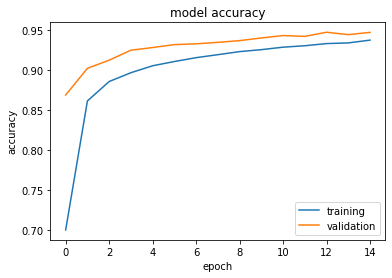

Test loss: 0.237
Test accuracy: 0.932


In [22]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=15, validation_split=.1)
loss, accuracy  = model.evaluate(x_test, y_test)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

## (Deep) Convolutional Neural Networks (CNN/DCNN)

CNNs are a type of neural network often used for image problems. CNNs and DCNNs contain layers called convolutional layers that behave differently from the usual fully connected layers that you see in neural networks.

The images below come from https://brohrer.github.io/how_convolutional_neural_networks_work.html which offers a more in depth explanation.

"Regular" neural networks are less effective when working with images as every pixel is considered separately when calculating probabilities. This means that a normal fully-connected neural network is not good at classifying images, for example, if the object moves in the scene.

Convolutional layers learn to look for *features* that are found in an image of certain classes. This is useful because it means that early on in a computation the model is not looking for specific *things* but rather simpler features like edges and corners.

To look for these features, the convolutional layers learn *filters* that are applied accross the image using a sliding window. This window finds how similair the filter being applied and the region of the image is.

Early in the computation, the filters are looking for edges and corners, then evenutally uses these edges and corners to look for higher and higher level features. By the end of the computation, filters are being learned to look for very high level features.

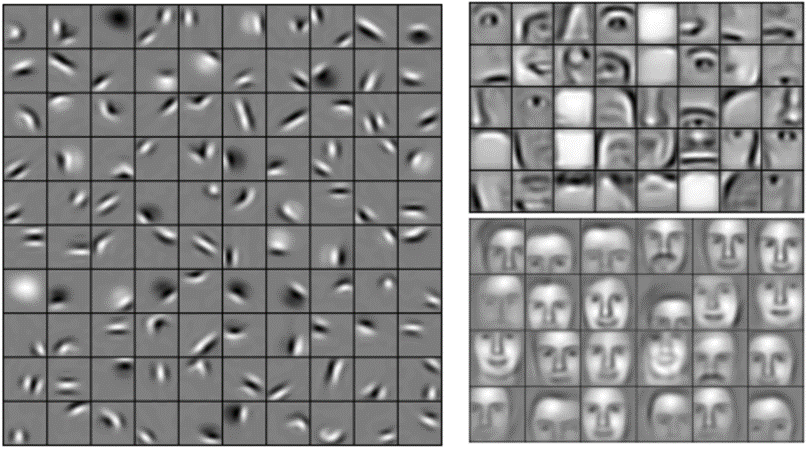

In [23]:
show_image('cnn4.png')

After features are extracted by the convolutional layers, this high level data is fed into a regular neural network which learns which features correspond to which outputs.

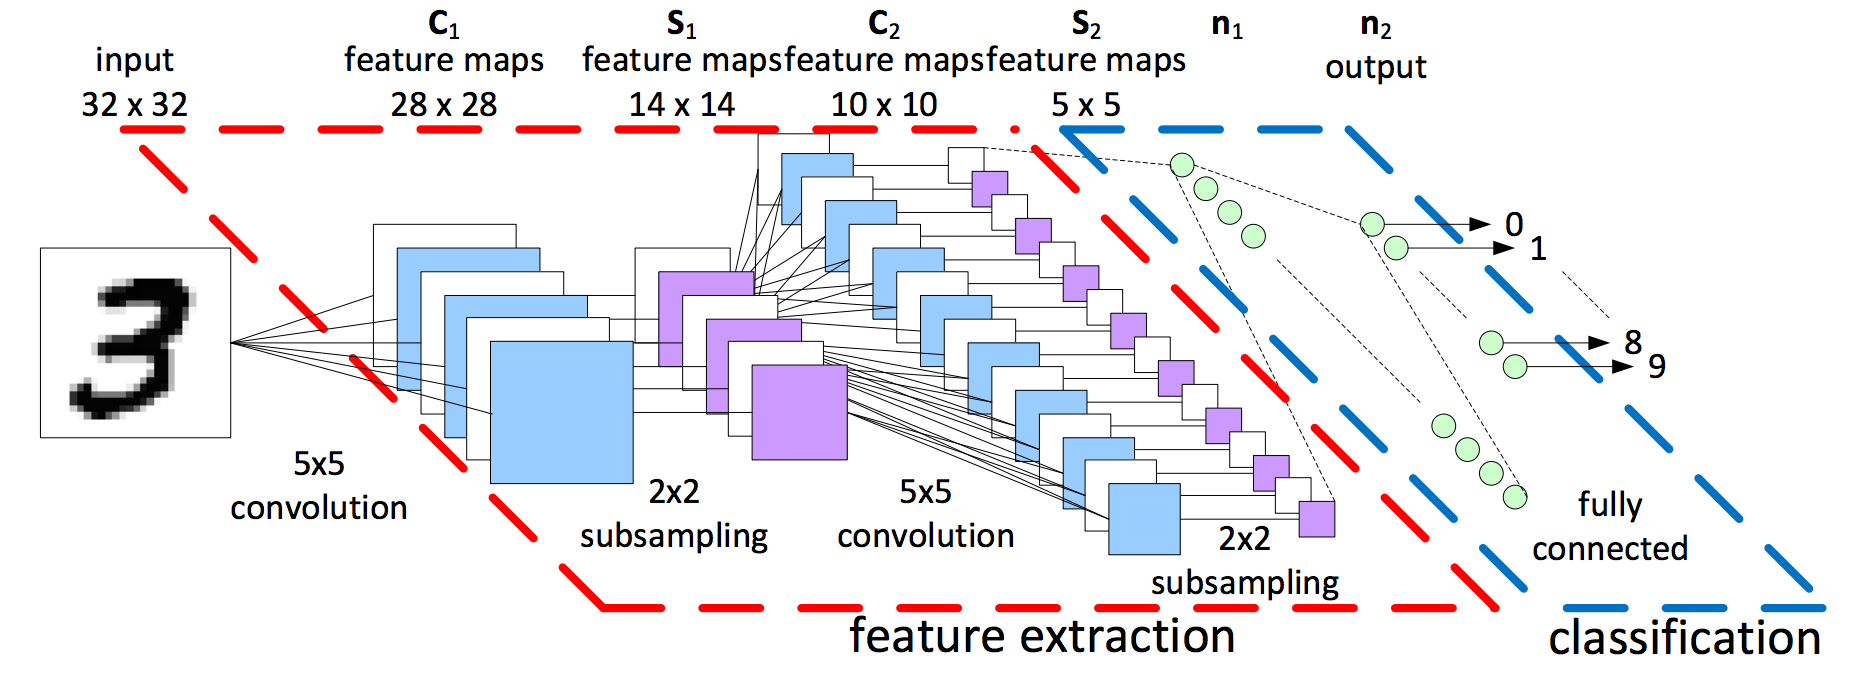

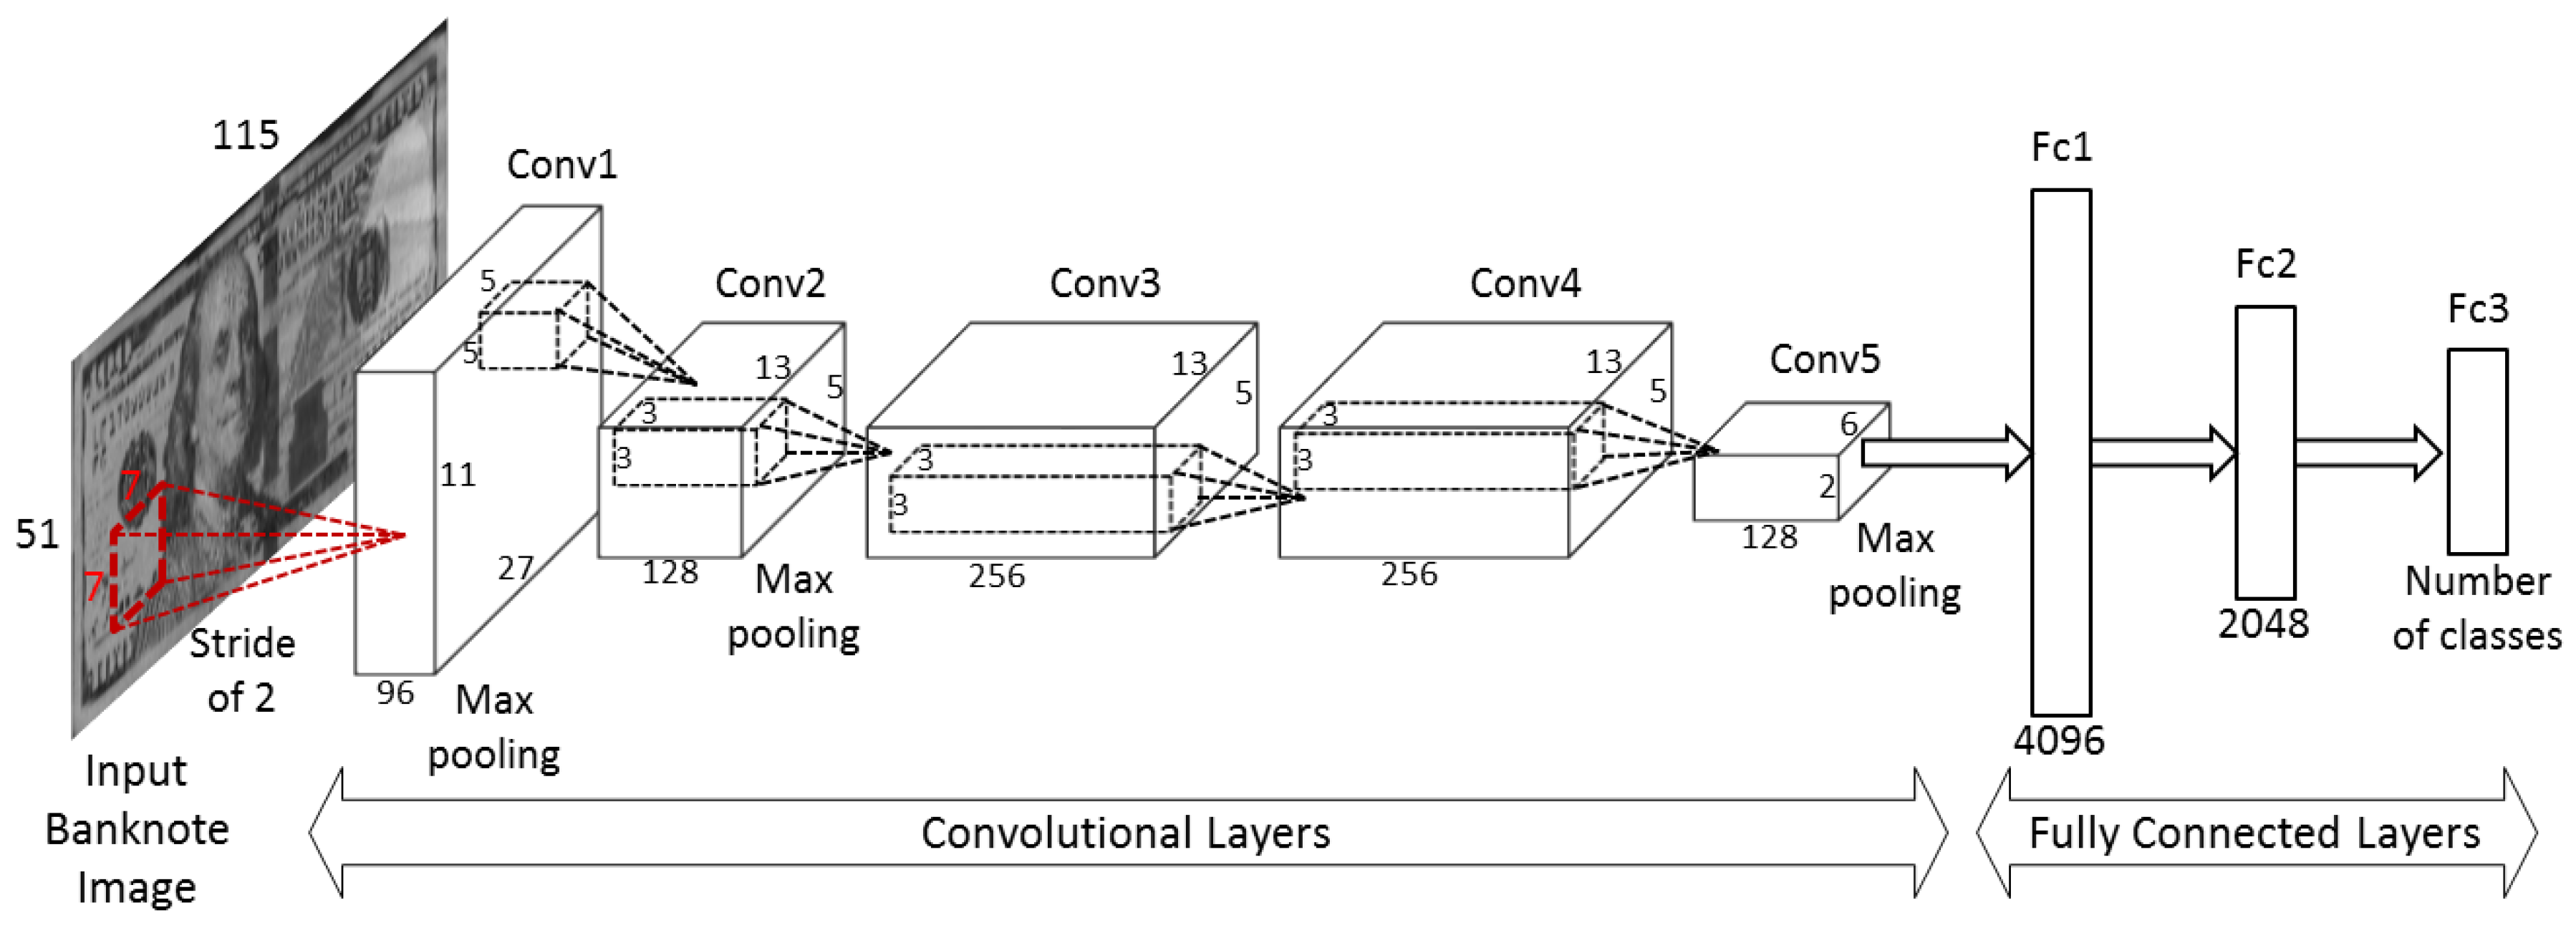

In [24]:
show_image('cnn5.png')
show_image('cnn7.png')

### Download dataset

In [25]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

batch_size = 128
num_classes = 10
epochs = 2

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

### Prepare Dataset

In [26]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Define the model

In [27]:
model = Sequential()
model.add(Conv2D(8, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

### Compile and train

In [28]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 19s 319us/sample - loss: 0.6989 - accuracy: 0.7721 - val_loss: 0.1345 - val_accuracy: 0.9643
Epoch 2/2
60000/60000 [==============================] - 21s 356us/sample - loss: 0.3325 - accuracy: 0.8958 - val_loss: 0.0860 - val_accuracy: 0.9739
Test loss: 0.08597324721030891
Test accuracy: 0.9739


In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                73760     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)               